In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Strain

We assume that the material particle original located at $(x, y)$ gets moved to the location $x' = x + u_x(x, y), y' = y + u_y(x, y)$.

So, we call $u_i(x, y)$ the deformation.  It is represented with two $N$ by $N$ matrices, giving the x deformation and y deformation.

We assume that the gradients of the deformation are small.  This is the standard assumption for linear elasticity.
Under this assumption, we can define the Cauchy strain tensor to be 

$$ u_{ij} = \nabla_i u_j + \nabla_j u_i $$

This tensor is symmetric, so there are 3 independent components in 2 dimensions. 

The next function computes the strains from the deformations

In [ ]:
def strains(Ux, Uy, dx):
    Uxx = np.gradient(Ux, dx, axis=1, edge_order=2)
    Uyy = np.gradient(Uy, dx, axis=0, edge_order=2)
    Uxy = (1./2)*(np.gradient(Ux, dx, axis=0, edge_order=2) + np.gradient(Uy, dx, axis=1, edge_order=2))
    return (Uxx, Uyy, Uxy)

## Stress

Once we have the strains, we can use Hooke's law to compute the stresses.  Hooke's law posits a linear relationship between strains to stresses.
Furthermore, we assume the material is homogeneous and isotropic.  Homogeneous means that the linear relationship is the same everywhere in the material.
Isotropic means that there are no preferred directions. 

These assumptions restrict the form that the linear relationship can have.  There can be only two terms: one proportional to the strain tensor itself, and the other proportional to its trace. 
So we define 

$$ \sigma_{ij} = 2 \mu u_{ij} + \lambda \Sigma_k u_{kk} $$

The function below computes the stresses from the strain tensor

In [ ]:
def stresses(Uxx, Uyy, Uxy, mu, lam):
    sxx = (2*mu +lam)*Uxx + lam*Uyy
    syy = (2*mu + lam)*Uyy + lam*Uxx
    sxy = 2*mu*Uxy
    syx = sxy
    return (sxx, syy, sxy, syx)

## Material Parameters
$ \mu $ and $ \lambda $ are called Lame parameters.  They are related to the more well-known material parameters called the Young's modulus and the Poisson ratio.  Here are two functions to compute the Lame parameters from Young's modulus and the Poisson ratio.

In [ ]:
def lam(E, nu):
    return (E*nu) / ((1-2*nu)*(1+nu))

def mu(E, nu):
    return E / (2*(1+nu))

## Total Force Density

Consider a small material box located at $x, y$.  What is the total force due to stress in the $x$-direction? 
Let's sum up all of the forces on the sides of the box in the $x$ direction.

First, we have normal stresses on the faces normal to the x direction.  if the width of the box is $dx$, then the total force is

$$
F_x = \sigma_{xx}(x+dx, y) - \sigma_{xx}(x, y) \approx \partial_x \sigma_{xx} (x, y)
$$

But we could also have forces in the x direction acting on the surfaces normal to the y axis: these are the shear stresses.  So we have to add them:

$$
F_x = \partial_x \sigma_{xx} (x, y) + \sigma_{yx}(x, y+dx) - \sigma_{yx}(x, y) \approx \partial_x \sigma_{xx} (x, y) + \partial_y \sigma_{yx} (x, y)
$$

Thus, the total force on the material box due to stress is the divergence of the stress tensor:

$$
F_j = \nabla_i \sigma_{ij}
$$

What other forces act on the box?  Well, there could be body forces such as gravity that act on the whole particle itself, so we must include them:

$$
F_j = \nabla_i \sigma_{ij} + \rho g_j + f_j
$$

Where $g_i$ is the local gravitational acceleration vector, and $f_j$ represents any other forces present.

Let's define a function to compute the total force at each point in our material from the stresses, gravity, and whatever else we want:

In [ ]:
def force(sxx, syy, sxy, syx, rho, g, dx, Fx=None, Fy=None):
    '''
    sxx : Normal stress in x direction
    syy : Normal stress in y direction
    syx : Shear stress
    rho : Material density
    g   : y component of downward gravitational acceleration
    Fx  : External x-directed body force
    Fy  : External y-directed body force
    
    '''
    if Fx is None:
        Fx = np.zeros_like(sxx)
    if Fy is None:
        Fy = np.zeros_like(syy)
    
    # Total force is divergence of stress tensor plus body forces
    fx = np.gradient(sxx, dx, axis=1, edge_order=2) + np.gradient(syx, dx, axis=0, edge_order=2) + Fx
    fy = np.gradient(sxy, dx, axis=1, edge_order=2) + np.gradient(syy, dx, axis=0, edge_order=2) - rho*g + Fy
    return (fx, fy)

### Equilibrium Equation

We now have enough available to define the problem we are trying to solve.  
We would like to know how an elastic body deforms when subject to various forces, such as its own weight. 
After deforming, the body will be at rest with no net accelerations. 
Newton's second law tells us that to have no net acceleration, all forces must some to zero. 

Since we are working with a continuum body, we want the accelerations of each material particle to be zero. 
This means that the total force density must equal zero. So, to summarize, we seek a vector function $u_i(x, y)$ that gives the deformation of the material particle located at $(x, y)$.  This deformation must be a solution to the system of partial differential equations

$$
\nabla_i \sigma_{ij} + F_j = 0
$$

$$ 
\sigma_{ij} = 2\mu u_{ij} + \lambda u_{ii}
$$

$$
u_{ij} = \nabla_i u_j + \nabla_j u_i
$$


### Boundary Conditions

Every partial differential equations needs boundary conditions. 
For simplicity, our domain is a square region in the x-y plane, so we have four boundaries. 
Since our partial differential equation is a second order differential equation for $u$, we need a condition on either the function itself or its derivative.  Since the stress depends linearly on the derivatives of the deformation, it will be more intuitive to impose boundary conditions on the stress rather than the derivative of the deformation itself.

If a particular component of the stress vector at a boundary vanishes, that means there is no contact force acting on that boundary. Thus, that boundary is "free" in the sense that it can move wherever it needs.

If a deformation component vanishes at the boundary, then that boundary is "fixed" and cannot move.  The surface to which it is attached will provide whatever stres is necessary at that boundary to maintain equilibrium. 

Here is a function to force the boundaries of our approximate solution to adhere to the appropriate boundary conditions.

In [325]:
def set_boundary(sxx, syy, sxy, syx, Ux, Uy):
    # For a free boundary, the stress (s) has to be zero
    # For a constrained boundary, the deformation must be zero, but the stress can be whatever it needs to be to maintain zero deformation.  
    
    # Boundary at x = 0 (Left sized)
    Ux[:, 0] = 0     # Fixed - no movement in the x direction
    syx[:, 0] = 0    # No shear stress in y direction - surface may slide along x = 0 plane
    #sxx[:, 0] = 0   # No normal stress in x direction - surface is free. 
    #Uy[:, 0] = 0    # No deformation in y direction - surface cannot slide along x = 0 plane. 

    
    # Boundary at y = 0 (Bottom)
    Uy[0, :] = 0     # Body may not fall through the floor
    sxy[0, :] = 0    # Body may slide along the floor
    #syy[0, :] = 0   # Bottom surface is free, away from floor
    #Ux[0, :] = 0    # Body may not slide along floor
    
    # Boundary at x = 1 (Right side)
    sxx[:, -1] = 0   # Free surface
    syx[:, -1] = 0   # Free surface 
    #Ux[:, -1] = 0   # Fixed in x direction
    #Uy[:, -1] = 0   # Fixd in y direction
    
    # y = b
    syy[-1, :] = 0
    sxy[-1, :] = 0
    
    return (sxx, syy, sxy, syx, Ux, Uy)
    
    

In [372]:
N = 20
Ux = np.zeros((N, N))
Uy = np.zeros((N, N))
dx = 1./N

E = 2
nu = 1./3

m = mu(E, nu)
l = lam(E, nu)

rho=1
g=2

eps = (0.9/E)*(dx**4 / (2*dx**2))

#Fx, Fy = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N))
#Fx = np.sinc(Fx)
#Fy = np.sinc(Fy)
ITS = 2000
forces = np.zeros(ITS)
for it in range(ITS):
    (Uxx, Uyy, Uxy) = strains(Ux, Uy, dx)
    (sxx, syy, sxy, syx) = stresses(Uxx, Uyy, Uxy, m, l)
    
    (sxx, syy, sxy, syx, Ux, Uy) = set_boundary(sxx, syy, sxy, syx, Ux, Uy)
    (fx, fy) = force(sxx, syy, sxy, syx, rho, g, dx)
    dUx = eps*fx
    dUy = eps*fy
    Ux += dUx
    Uy += dUy
    forces[it] = np.sum(dx*dx*np.sqrt(fx**2 + fy**2))
    (sxx, syy, sxy, syx, Ux, Uy) = set_boundary(sxx, syy, sxy, syx, Ux, Uy)

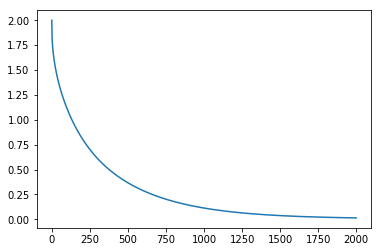

In [373]:
plt.plot(forces)

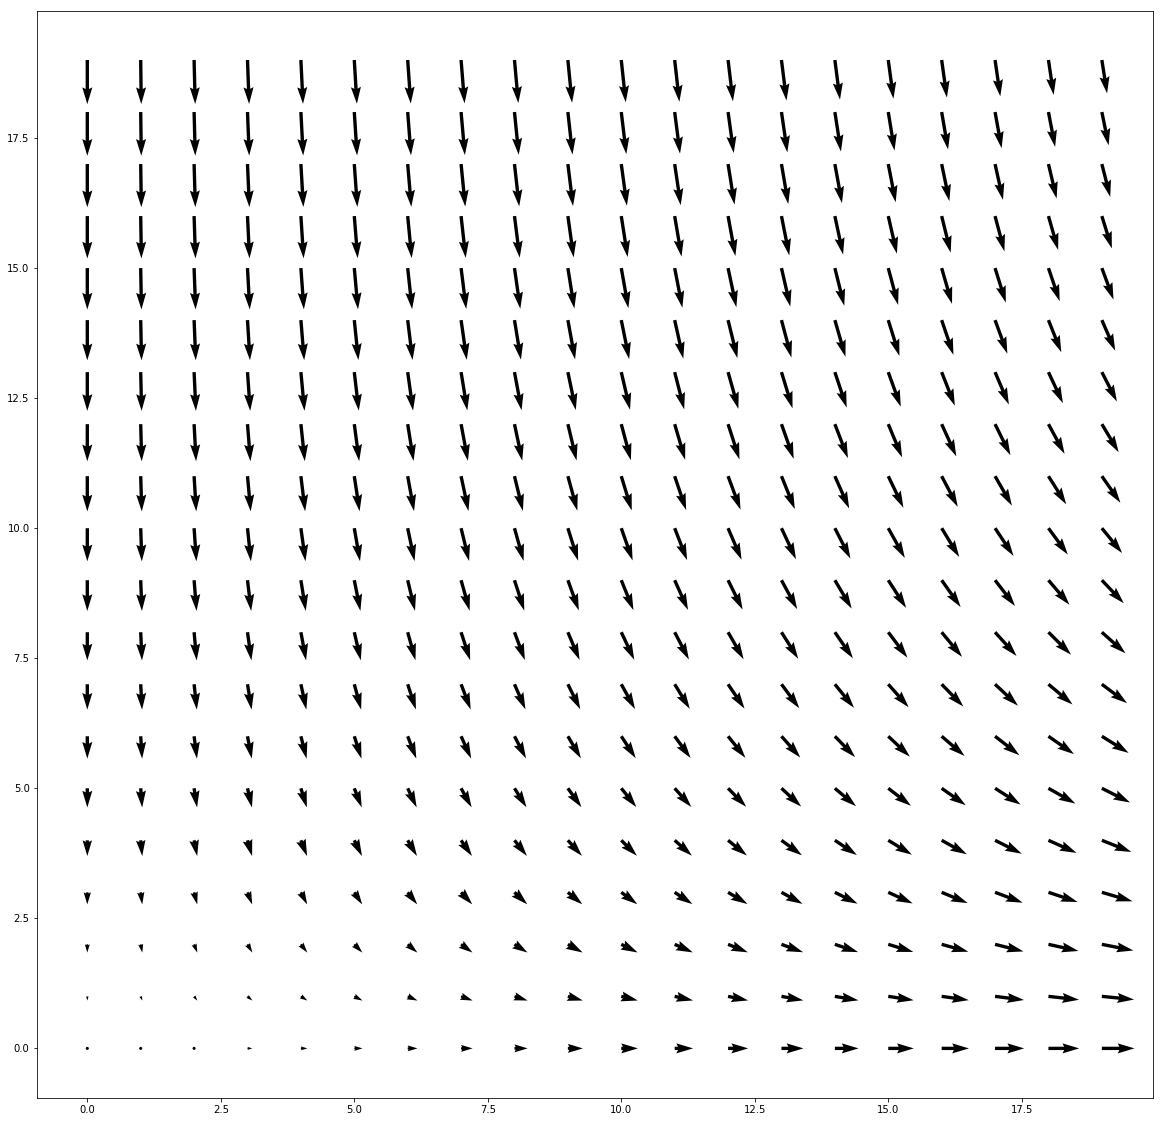

In [374]:
plt.figure(figsize=(20, 20))
plt.quiver(Ux, Uy)

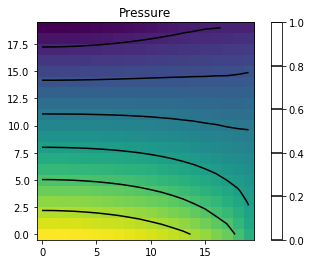

In [375]:
plt.imshow(-(sxx + syy)/2, origin='lower', aspect='equal')
plt.contour(-(sxx+syy)/2, colors='black')
plt.title('Pressure')
plt.colorbar()

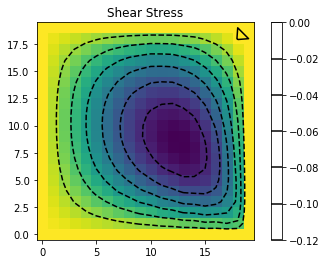

In [370]:
plt.imshow(sxy, origin='lower', aspect='equal')
plt.contour(syx, colors='black')
plt.title('Shear Stress')
plt.colorbar()

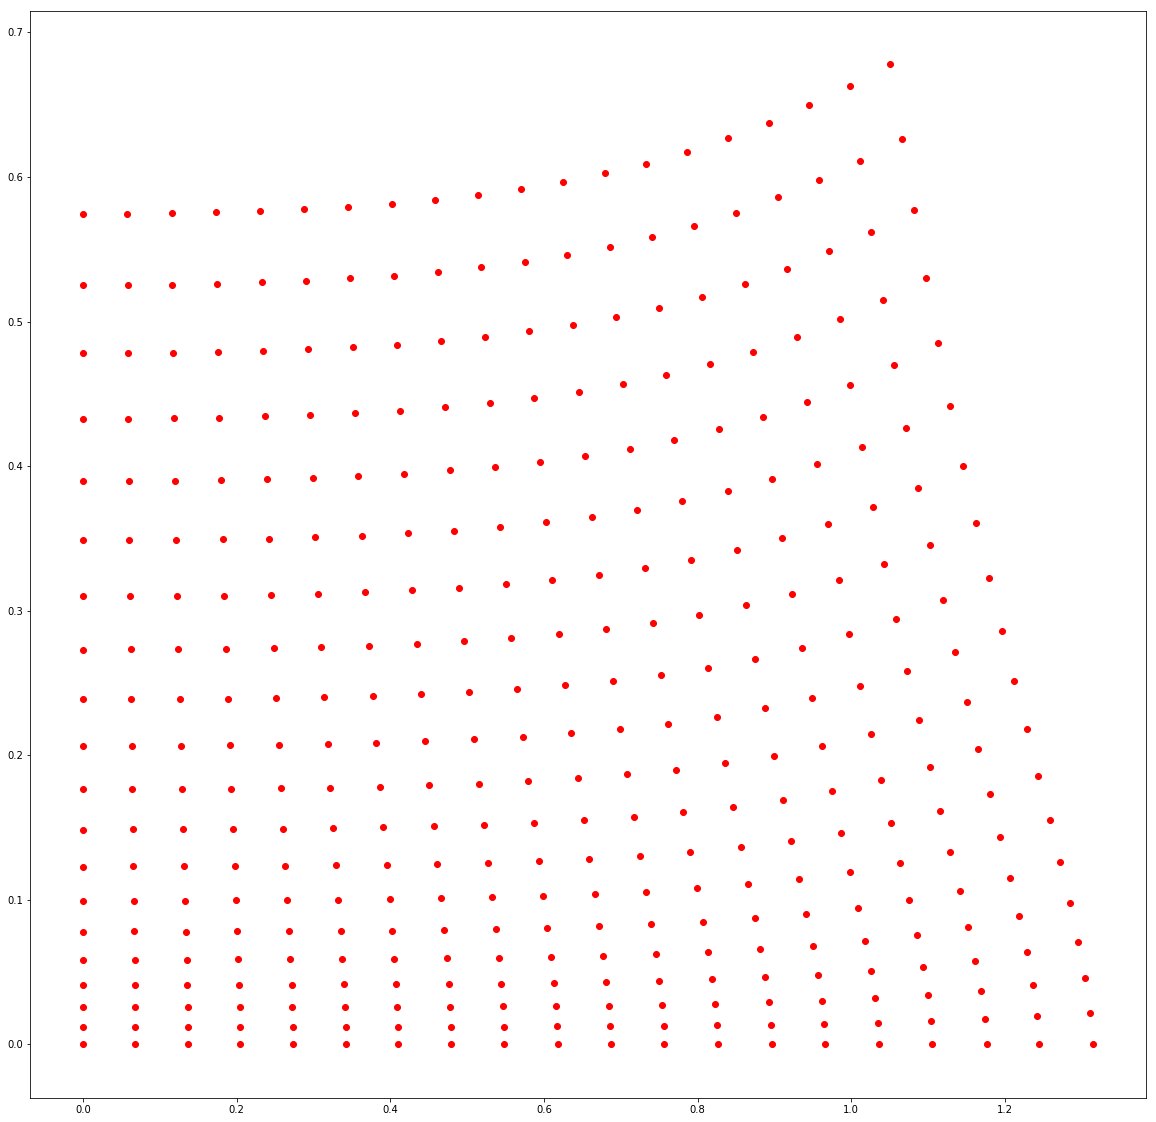

In [376]:
X, Y = np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))

plt.figure(figsize=(20, 20))
#plt.scatter(X, Y, c='black')
plt.scatter(X + Ux, Y+Uy, c='red')